# 1. ALL FUNCTIONS (please do not change anything)

In [1]:
# Install packages
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

### Preparing the Dataset

In [2]:
# Code for data preparation
def data_preparation(dataset, relevant_columns):
    df_main = dataset.copy()
    df_main.replace(["", "-", "0"], np.nan, inplace=True)   # Convert potential empty strings or placeholders into NaN
    df_main = df_main.dropna(subset=relevant_columns)       # Remove missing values
    df_main.reset_index(drop=True, inplace=True)

    # Apply Standardization (Z-score normalization)
    scaler = StandardScaler()
    df_main[relevant_columns] = scaler.fit_transform(df_main[relevant_columns])

    return df_main

### Correlation Analysis

In [3]:
# Function to plot correlation matrix
def correlation_matrix(var, df):
    # Compute the correlation matrix
    variables_corr = df[var]
    corr_matrix = variables_corr.corr()

    # Plot the correlation matrix with numbers inside each block
    fig, ax = plt.subplots(figsize=(26, 20))
    cax = ax.matshow(corr_matrix, cmap='coolwarm')
    
    # Adding numbers inside each cell
    for (i, j), val in np.ndenumerate(corr_matrix):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
        
    # Adding color bar and labels
    plt.colorbar(cax)
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45)
    ax.set_yticklabels(corr_matrix.index)
    plt.title("Correlation Matrix with Numbers", pad=20)
    
    plt.show()

### Support Vector Method (LINEAR) + RFE

In [4]:
# Function to select & fit with Support Vector Method (linear)
def SVM_linear_select_fit(X, y, n_features = 2, split_data=False, test_size=0.3, random_state=42):
    
    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")    
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Initialize the SVR model
    svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
    
    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=svr, n_features_to_select=n_features)  # Select 3 features
    rfe_model = rfe.fit(X_train, y_train)
    
    # Transform the dataset to only include selected features
    X_train_rfe = rfe.transform(X_train)

    # Only transform test data if split_data is True
    if split_data:
        X_test_rfe = rfe.transform(X_test)
        X_rfe = rfe.transform(X)
    else:
        X_test_rfe = None
        X_rfe = None

    # Selected features
    selected_features = rfe.support_
    print("Selected Features (after refit):", selected_features)

    # Map indices to actual feature names if available
    if hasattr(X_train, 'columns'):
        select_feat_SVM = X_train.columns[rfe.support_]
        print("Selected Features Names (after refit):", select_feat_SVM)

    # Ranking of features
    feature_ranking = rfe.ranking_
    print("Feature Ranking:", feature_ranking)

    # Fit the model to the training data
    svr_model = svr.fit(X_train_rfe, y_train)

    # Check convergence
    if hasattr(svr_model, 'n_iter_'):
        print(f"Support Vector Method converged in {svr_model.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model
    else:
        return X_train_rfe, select_feat_SVM, svr_model


# Function to extract coefficients
def SVM_coefficients(svr_model):
    # extract coefficients
    SVM_coeff = svr_model.coef_.flatten() # Flatten bc it is multi-dimensial array, 'enumerate' won't work if not flattened
    print("SVM coefficients (after refit):", SVM_coeff)

    return SVM_coeff


# Function to predict SVM
def predict_SVM(X_test_rfe, y_test, svr_model):

    # Make predictions on the test data
    y_pred = svr_model.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

### Elastic Net (Lasso + Ridge)

In [5]:
# Function to fit with Elastic Net (Lasso+Ridge)
def elastic_net_fit_all(X, y, split_data=False, test_size=0.3, random_state=42):

    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Define the Elastic Net model
    elastic_net = ElasticNet(max_iter=1000000)

    # Perform grid search to tune hyperparameters
    param_grid = {
        'alpha': [0.1, 1, 10],  # Regularization strength
        'l1_ratio': [0.1, 0.5, 0.9]  # Mix of Lasso and Ridge (alpha in formula)
    }
    grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model to the data
    EN_model_all = grid_search.fit(X_train, y_train)

    # Best estimators based on best hyperparameters
    EN_hyperparams = EN_model_all.best_estimator_
    print("Best Hyperparameters:", EN_model_all.best_params_)

    # Coefficients of the selected model
    EN_coeff_all = EN_hyperparams.coef_
    EN_coeff_nonzero = EN_coeff_all[EN_coeff_all != 0]

    # Print coefficients with variable names if x is a DataFrame
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(len(EN_coeff_all))]  # Default to generic names

    # Print feature names and their corresponding coefficients
    print("\nAll Feature Coefficients (before refit):")
    for feature, coef in zip(feature_names, EN_coeff_all):
        print(f"{feature}: {coef:.4f}")

    # Check convergence
    if hasattr(EN_model_all, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_all.n_iter_} iterations.")
    else:
        print("Convergence information not available.")
    
    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all
    else:
        return EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all


# Function to select features from Elastic Net
def elastic_fit_select(x, y, EN_hyperparams, X_train=None, X_test=None, y_train=None, n_features=2):

    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=EN_hyperparams, n_features_to_select=n_features)

    # Only transform test data if data was splitted before
    if X_train is not None and X_test is not None and y_train is not None:
        rfe.fit(X_train, y_train)
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        X_rfe = rfe.transform(x)
    else:
        rfe.fit(x, y)
        y_train = y
        X_train_rfe = rfe.transform(x)
        X_test_rfe = None
        X_rfe = None

    # Select feature indices from RFE
    selected_indices = np.where(rfe.support_)[0]

    # Map indices to actual feature names if available
    if hasattr(x, 'columns'):
        selected_feat_EN = x.columns[selected_indices].tolist()
    else:
        selected_feat_EN = selected_indices.tolist()  # Return indices if no feature names

    # Retrain Elastic Net on selected features
    EN_retrained = ElasticNet(alpha=EN_hyperparams.alpha, l1_ratio=EN_hyperparams.l1_ratio, max_iter=10000)
    EN_model_refit = EN_retrained.fit(X_train_rfe, y_train)
    EN_best_coeff = EN_model_refit.coef_

    print(f"\nSelected Features (after refit): {selected_feat_EN}")
    print(f"Selected Feature Coefficients (after refit): {EN_best_coeff}")

    # Check convergence
    if hasattr(EN_model_refit, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_refit.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if X_train is not None and X_test is not None and y_train is not None:
        return selected_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff
    else:
        return selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff


# Function to predict EN
def elastic_predict(X_test_rfe, y_test, EN_model_refit):
    # Make predictions on the test data
    y_pred = EN_model_refit.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

### Validation plots & Cross-validation

In [6]:
from sklearn.model_selection import cross_val_score

# Function to visualize feature importances linear SVM (optional)
def visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff):
    plt.bar(select_feat_SVM, SVM_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (SVM)')
    plt.show()

# Function to visualize feature importances EN (optional)
def visualize_feature_importances_EN(select_feat_EN, EN_best_coeff):
    plt.bar(select_feat_EN, EN_best_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (Elastic Net)')
    plt.tight_layout()
    plt.show()

# Function to plot actual vs prediction results (optional)
def plot_pred_actual_results(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # Diagonale lijn
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.title('Regression Results')
    plt.show()

# Function for cross_validation
def cross_validation(select_method, x, y):
    # Perform 5-fold cross-validation
    scores = cross_val_score(select_method, x, y, cv=5, scoring='r2')
    print("Cross-validated R^2 scores:", scores)
    print("Mean R^2 score:", scores.mean())

# 2. Users Part: fill in information

### Resistance_variables_Sietse: select variables for Rtot (kN) based on lots of variables

In [7]:
# 1. Copy the path to the desired excel below between the brackets. Make sure all the slashes are '\' instead of '/'
path = "J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Resistance_variables_Sietse.xlsx"
df_main = pd.read_excel(path)

# Show part of dataset
df_main.head()

,YardNb,Design revision,Vs (kn),T (m),Rf (kN),Rp (kN),Rtot (kN),Lwl (m),Los (m),Bmld (m),...,L/V (-),B/T (-),Cb (-),Cp (-),Cm (-),Cwp (-),Conventional,Pods,nBT (-),dBT (m)
0,3478,DN3478_AH_revA_20220603,12.0,3.82,46.4,49.3,95.7,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
1,3478,DN3478_AH_revA_20220603,15.0,3.82,72.7,105.6,178.3,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
2,3478,DN3478_AH_revA_20220603,16.0,3.82,83.3,129.3,212.6,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
3,3478,DN3478_AH_revA_20220603,17.0,3.82,94.9,159.6,254.5,85.985,85.988,13.906,...,6.478411,3.640314,0.512,0.641,0.799,0.826,0,1,1,1
4,1013,BN1013_AH_revD_T4000,12.0,4.00,63.0,56.5,119.5,100.442,100.442,15.472,...,6.900003,3.868000,0.496,0.643,0.772,0.778,1,0,1,1


In [8]:
# 2. Fill in the names of ALL the columns you want to use in the Correlation Analysis
relevant_columns = df_main.columns[~df_main.columns.isin(['YardNb', 'Design revision', 'Conventional', 'Pods', 'nBT (-)', 'dBT (m)'])]

# See the dataset
df_main = data_preparation(df_main, relevant_columns)
#df_main['Loa'] = pd.to_numeric(df_main['Loa'], errors='coerce')
#df_main['Lwl'] = pd.to_numeric(df_main['Lwl'], errors='coerce')
#df_main['Lav'] = ((df_main['Loa']+df_main['Lwl'])/2)
df_main

,YardNb,Design revision,Vs (kn),T (m),Rf (kN),Rp (kN),Rtot (kN),Lwl (m),Los (m),Bmld (m),...,L/V (-),B/T (-),Cb (-),Cp (-),Cm (-),Cwp (-),Conventional,Pods,nBT (-),dBT (m)
0,3478,DN3478_AH_revA_20220603,-0.712671,0.256731,-0.574022,-0.681601,-0.647607,0.263865,0.190694,0.242257,...,0.032927,0.006517,-0.064674,-0.559985,0.344418,0.920085,0,1,1,1
1,3478,DN3478_AH_revA_20220603,0.150380,0.256731,-0.104296,0.109552,0.015711,0.263865,0.190694,0.242257,...,0.032927,0.006517,-0.064674,-0.559985,0.344418,0.920085,0,1,1,1
2,3478,DN3478_AH_revA_20220603,0.438064,0.256731,0.085023,0.442594,0.291156,0.263865,0.190694,0.242257,...,0.032927,0.006517,-0.064674,-0.559985,0.344418,0.920085,0,1,1,1
3,3478,DN3478_AH_revA_20220603,0.725748,0.256731,0.292203,0.868383,0.627633,0.263865,0.190694,0.242257,...,0.032927,0.006517,-0.064674,-0.559985,0.344418,0.920085,0,1,1,1
4,1013,BN1013_AH_revD_T4000,-0.712671,0.594289,-0.277541,-0.580423,-0.456481,1.180923,1.046185,0.987991,...,0.919799,1.237561,-0.502464,-0.511625,-0.070729,-1.576344,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,707,BN707_AH_revT_20200826,1.301115,-0.343371,0.395792,1.126948,0.821970,-0.877114,-0.611351,-0.719672,...,-0.192449,-1.314433,0.154222,0.020333,0.083029,1.388166,1,0,1,1
216,705,BN705_AH_revP_20180416,-0.712671,-0.268358,-0.609742,-0.912061,-0.795367,-1.190158,-0.991273,-0.407759,...,-1.475252,-0.521501,0.154222,-0.294006,0.313667,0.452005,1,0,1,1
217,705,BN705_AH_revP_20180416,0.438064,-0.268358,0.051089,0.063178,0.059075,-1.190158,-0.991273,-0.407759,...,-1.475252,-0.521501,0.154222,-0.294006,0.313667,0.452005,1,0,1,1
218,705,BN705_AH_revP_20180416,-0.712671,-0.118333,-0.602598,-0.864282,-0.764851,-1.197643,-0.991273,-0.408236,...,-1.333250,-0.946295,0.291031,-0.197286,0.375170,0.504014,1,0,1,1


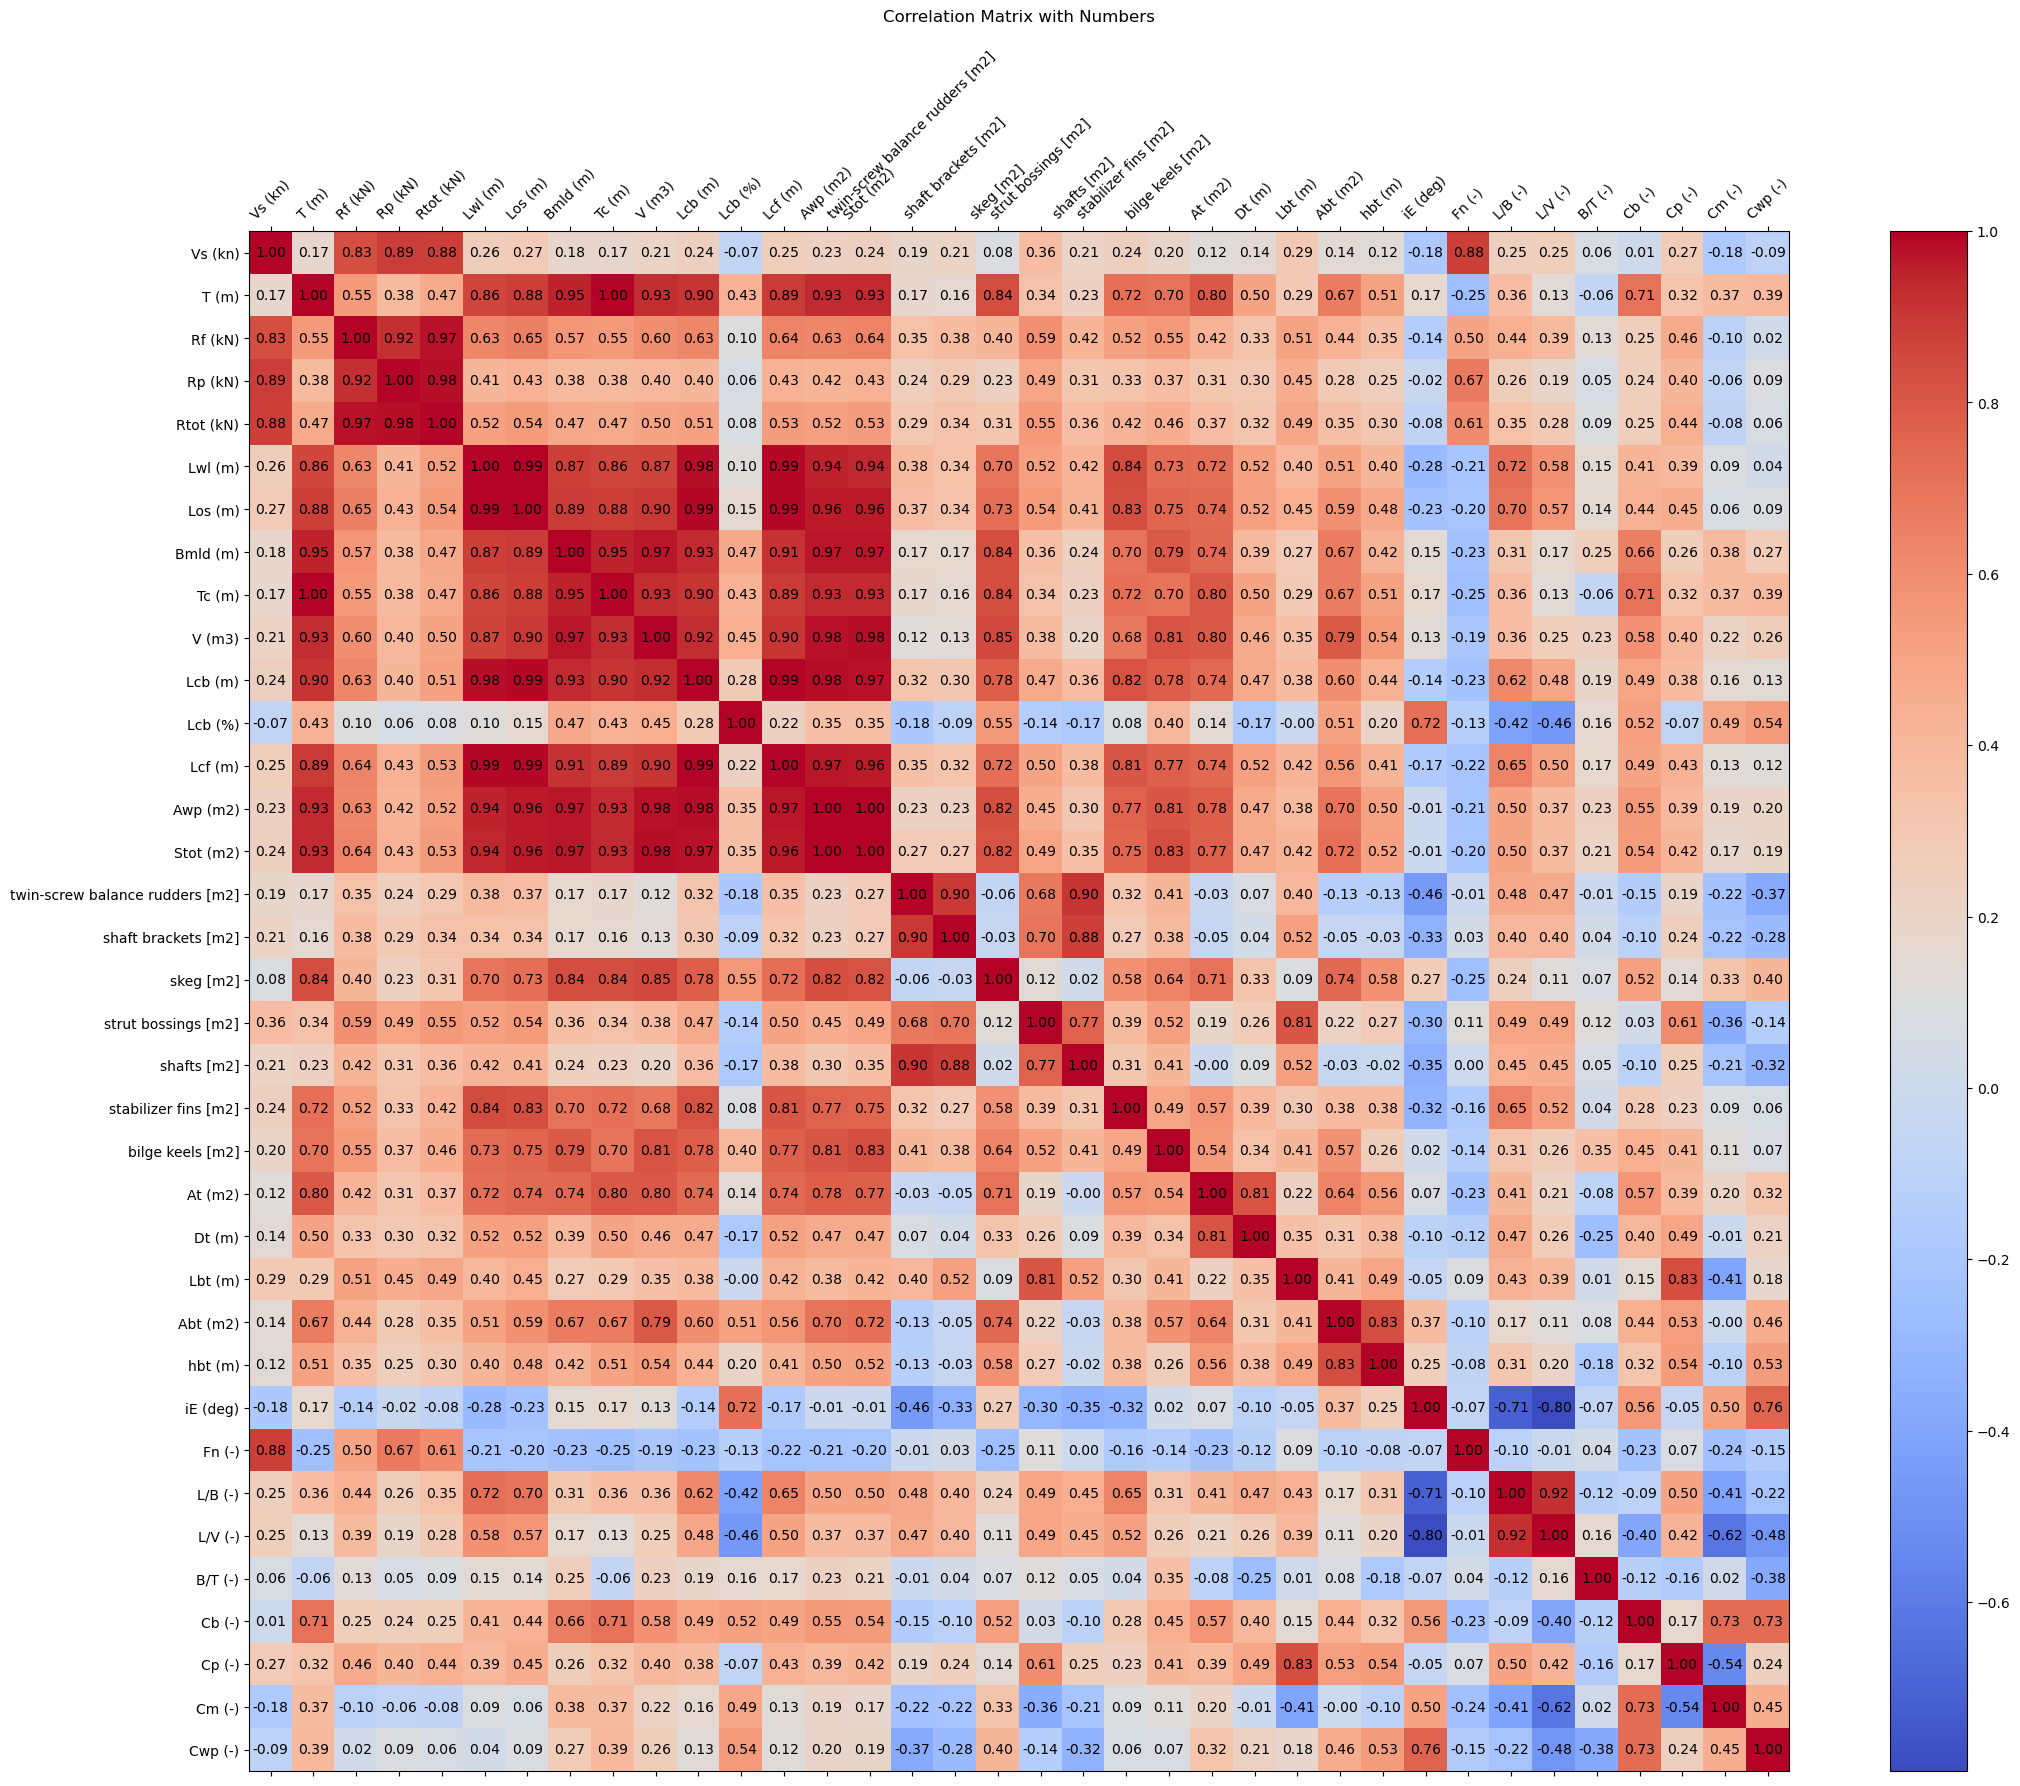

In [9]:
# 3. The Correlation matrix will be shown below
var_main = relevant_columns
correlation_matrix(var_main, df_main)

In [10]:
# 4. Fill in the column names of the variables X you want to include in the Selection Tool
X_main = df_main.loc[:, ~df_main.columns.isin(['Rtot (kN)', 'Rf (kN)', 'Rp (kN)', 'YardNb', 'Design revision', 'Conventional', 'Pods', 'nBT (-)', 'dBT (m)', 'Lcb (%)' ,'Cm (-)', 'Cp (-)', 'Cwp (-)', 'Cb (-)', 'L/V (-)', 'L/B (-)', 'Los (m)', 'Fn (-)', 'B/T (-)'])]
X_main = sm.add_constant(X_main)

# 5. Fill in the column name of the variable Y you want to predict
y_main = df_main['Rtot (kN)']

# 6. Fill in the number of most important features you eventually want to select
no_features = 5

## 3. Regression output results (please do not change anything here)

## SVM Linear + RFE

Training Set Size: 154 rows
Test Set Size: 66 rows
Selected Features (after refit): [False  True False False False  True False False  True False False False
 False False  True False False False False False False False False  True]
Selected Features Names (after refit): Index(['Vs (kn)', 'Tc (m)', 'Lcf (m)', 'strut bossings [m2]', 'iE (deg)'], dtype='object')
Feature Ranking: [20  1  8 17 13  1  3 14  1 10  6 18 12  2  1 16  9  7 11 19 15  4  5  1]
Support Vector Method converged in 1425 iterations.
SVM coefficients (after refit): [0.73271668 0.02381593 0.24027765 0.16995185 0.14683827]
Mean Squared Error: 0.06
R^2 Score: 0.91


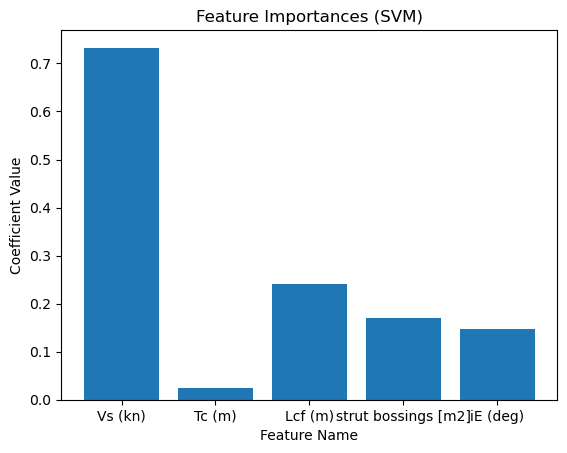

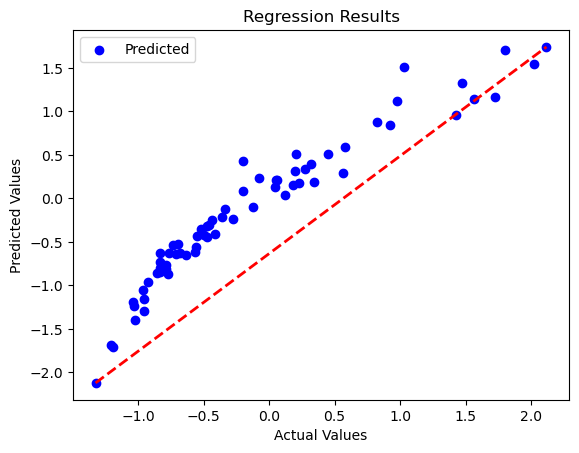

Cross-validated R^2 scores: [0.86569168 0.97184189 0.89911814 0.91285278 0.91077809]
Mean R^2 score: 0.912056516925008


In [11]:
##############
# SVM linear: splitting of dataset
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, split_data=True, n_features=no_features)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_main)

Selected Features (after refit): [False  True False False False False False False  True False False False
 False False  True False False False  True False False False False  True]
Selected Features Names (after refit): Index(['Vs (kn)', 'Lcf (m)', 'strut bossings [m2]', 'At (m2)', 'iE (deg)'], dtype='object')
Feature Ranking: [19  1 12 13  8  9  3 15  1 17 16 11  6  2  1 18 14 10  1  7 20  4  5  1]
Support Vector Method converged in 13175 iterations.
SVM coefficients (after refit): [0.73862317 0.19444765 0.13389685 0.06085319 0.12281442]
Mean Squared Error: 0.10
R^2 Score: 0.90


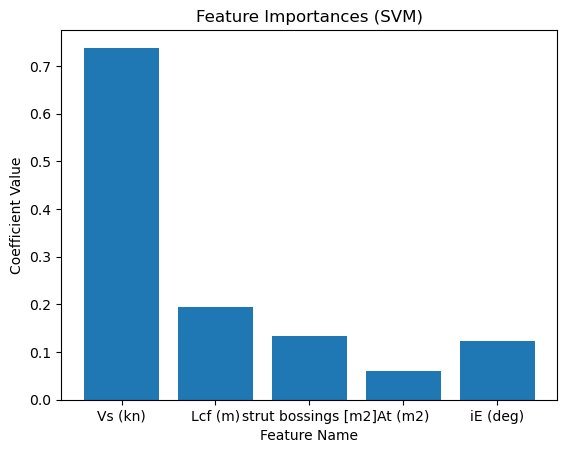

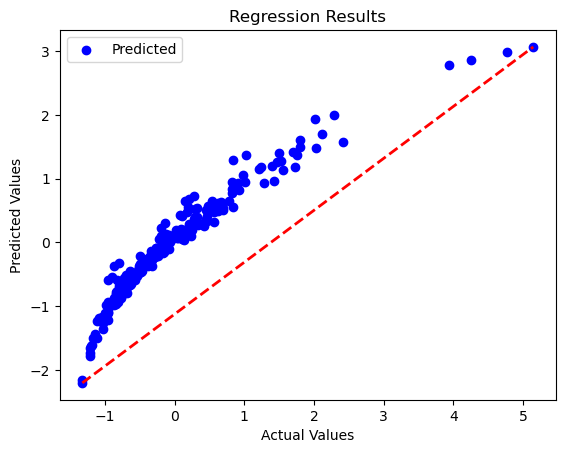

Cross-validated R^2 scores: [0.86541837 0.9754334  0.91309472 0.91230761 0.91565692]
Mean R^2 score: 0.9163822052826264


In [12]:
##############
# SVM linear: no splitting of dataset
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, n_features=no_features)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_train_rfe, y_main, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_main, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_train_rfe, y_main)

## Elastic Net (Lasso + Ridge)

Training Set Size: 154 rows
Test Set Size: 66 rows
Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1}

All Feature Coefficients (before refit):
const: 0.0000
Vs (kn): 0.7089
T (m): 0.0339
Lwl (m): 0.0000
Bmld (m): 0.0555
Tc (m): 0.0349
V (m3): 0.0217
Lcb (m): 0.0000
Lcf (m): 0.0452
Awp (m2): 0.0193
Stot (m2): 0.0125
twin-screw balance rudders [m2]: 0.0000
shaft brackets [m2]: 0.0372
skeg [m2]: -0.0000
strut bossings [m2]: 0.0937
shafts [m2]: 0.0040
stabilizer fins [m2]: -0.0000
bilge keels [m2]: 0.0221
At (m2): 0.0254
Dt (m): 0.0350
Lbt (m): 0.1085
Abt (m2): -0.0000
hbt (m): -0.0000
iE (deg): 0.0945
Convergence information not available.

Selected Features (after refit): ['Vs (kn)', 'T (m)', 'Bmld (m)', 'strut bossings [m2]', 'Lbt (m)']
Selected Feature Coefficients (after refit): [0.69645424 0.13737883 0.14160149 0.07639986 0.1619309 ]
Elastic Net converged in 26 iterations.
Mean Squared Error: 0.07
R^2 Score: 0.90


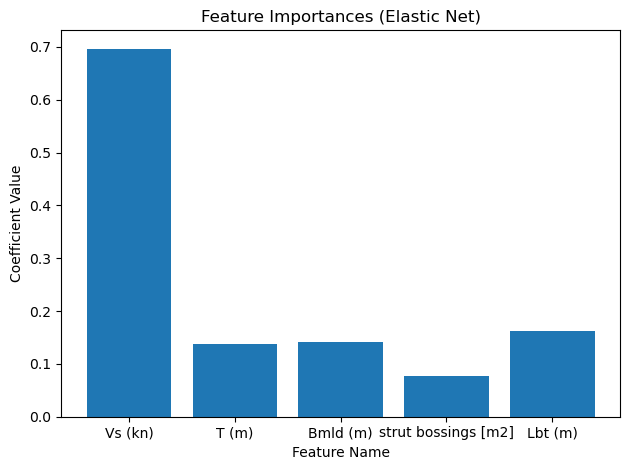

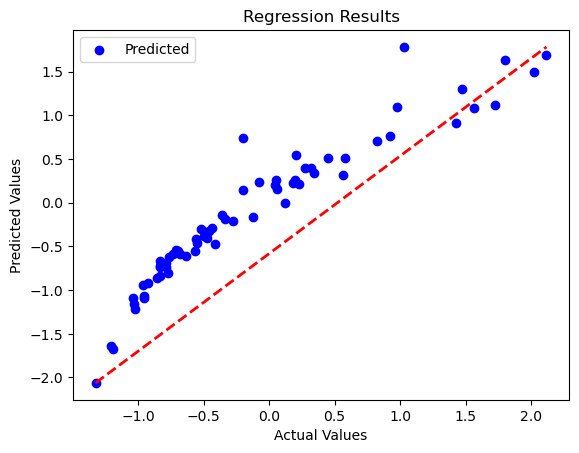

Cross-validated R^2 scores: [0.74685766 0.97655858 0.88004898 0.90787177 0.91636085]
Mean R^2 score: 0.8855395683081495


In [13]:
##############
# EN: splitting dataset
##############

# Extract all feature coefficients EN
X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_main, y_main, split_data=True)

# Refit with select number of most important features
select_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_main, y_main, EN_hyperparams, X_train=X_train, X_test=X_test, y_train=y_train, n_features=no_features)

# Prediction EN results
y_pred_EN = elastic_predict(X_test_rfe, y_test, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_test, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_rfe, y_main) # use selected features

Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1}

All Feature Coefficients (before refit):
const: 0.0000
Vs (kn): 0.6977
T (m): 0.0244
Lwl (m): 0.0006
Bmld (m): 0.0522
Tc (m): 0.0260
V (m3): 0.0254
Lcb (m): 0.0064
Lcf (m): 0.0498
Awp (m2): 0.0258
Stot (m2): 0.0223
twin-screw balance rudders [m2]: 0.0000
shaft brackets [m2]: 0.0329
skeg [m2]: -0.0000
strut bossings [m2]: 0.0803
shafts [m2]: 0.0267
stabilizer fins [m2]: 0.0000
bilge keels [m2]: 0.0029
At (m2): 0.0339
Dt (m): 0.0251
Lbt (m): 0.0781
Abt (m2): -0.0000
hbt (m): -0.0000
iE (deg): 0.0728
Convergence information not available.

Selected Features (after refit): ['Vs (kn)', 'T (m)', 'Bmld (m)', 'strut bossings [m2]', 'Lbt (m)']
Selected Feature Coefficients (after refit): [0.69225345 0.12837953 0.14056746 0.085256   0.12155977]
Elastic Net converged in 25 iterations.
Mean Squared Error: 0.10
R^2 Score: 0.90


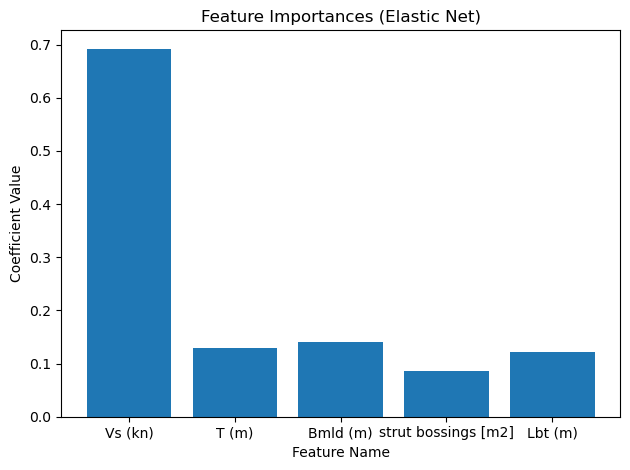

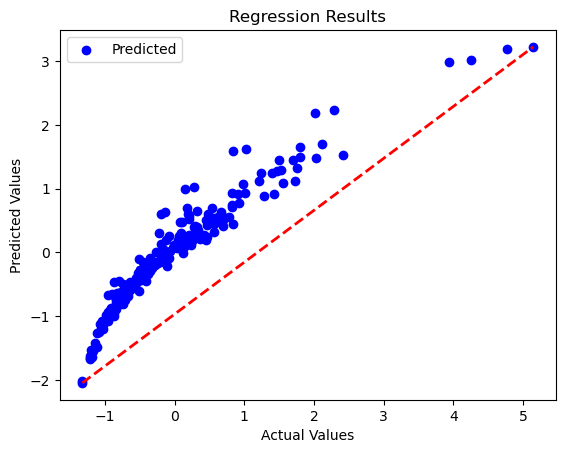

Cross-validated R^2 scores: [0.74685766 0.97655858 0.88004898 0.90787177 0.91636085]
Mean R^2 score: 0.8855395683081495


In [14]:
##############
# EN: no splitting of dataset
##############

# Extract all feature coefficients EN
EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_main, y_main)

# Refit with select number of most important features
selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_main, y_main, EN_hyperparams, n_features=no_features)
# More selected features leads to lower bias, but higher variance & prediction estimation error

# Prediction EN results
y_pred_EN = elastic_predict(X_train_rfe, y_main, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_main, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_train_rfe, y_main) # use selected features

### SVM nonlinear (Radial Basis Kernel)

In [15]:
from sklearn.inspection import permutation_importance

# Function voor nonlinear SVM
def SVM_nonlinear_select_fit(X, y, n_features=2, split_data=False, test_size=0.3, random_state=42):
    
    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")    
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.2]
    }
    svr = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='r2', n_jobs=-1)
    svr.fit(X_train, y_train)
    best_svr = svr.best_estimator_
    print("Best Hyperparameters:", svr.best_params_)

    # Initialize the SVR model with an Radial Basis Function kernel
    #svr = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')

    # Fit the model on the training data
    #svr.fit(X_train, y_train)
    
    # Compute feature importance using permutation importance
    perm_importance = permutation_importance(best_svr, X_train, y_train, scoring='r2', n_repeats=10, random_state=random_state)
    
    # Get the top n_features based on importance scores
    sorted_idx = perm_importance.importances_mean.argsort()[::-1][:n_features]
    selected_features = sorted_idx

    # Transform the dataset to only include selected features
    X_train_rfe = X_train.iloc[:, selected_features]

    # Only transform test data if split_data is True
    if split_data:
        X_test_rfe = X_test.iloc[:, selected_features]
        X_rfe = X.iloc[:, selected_features]
    else:
        X_test_rfe = None
        X_rfe = None

    # Selected features
    print("Selected Features Indices (after permutation importance):", selected_features)

    # Map indices to actual feature names if available
    if hasattr(X_train, 'columns'):
        select_feat_SVM = X_train.columns[selected_features]
        print("Selected Features Names (after permutation importance):", select_feat_SVM)

    # Fit the model to the training data
    svr_nonlinear = SVR(kernel='rbf', C=best_svr.C, epsilon=best_svr.epsilon, gamma=best_svr.gamma)
    svr_nonlinear = svr.fit(X_train_rfe, y_train)

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_nonlinear, perm_importance
    else:
        return X_train_rfe, select_feat_SVM, svr_nonlinear, perm_importance
    

# Function to predict
def predict_SVM_nonlinear(X_test_rfe, y_test, svr_nonlinear):
    # Make predictions on the test data
    y_pred = svr_nonlinear.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred


# Function to visualize feature importances nonlinear SVM (optional)
def visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance):
    # Extract importance values
    selected_importance_values = perm_importance.importances_mean[perm_importance.importances_mean.argsort()[::-1][:len(select_feat_SVM)]]
    
    # Plot feature importances
    plt.bar(select_feat_SVM, selected_importance_values)
    plt.xlabel('Feature Name')
    plt.ylabel('Permutation Importance Score')
    plt.title('Feature Importances (Non-Linear SVM - RBF Kernel)')
    plt.xticks(rotation=45)
    plt.show()

Training Set Size: 154 rows
Test Set Size: 66 rows
Best Hyperparameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Selected Features Indices (after permutation importance): [ 1 20 14  2  5]
Selected Features Names (after permutation importance): Index(['Vs (kn)', 'Lbt (m)', 'strut bossings [m2]', 'T (m)', 'Tc (m)'], dtype='object')
Mean Squared Error: 0.02
R^2 Score: 0.97


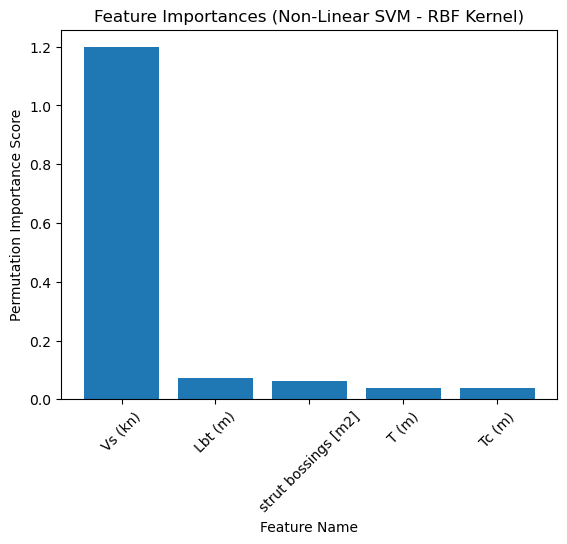

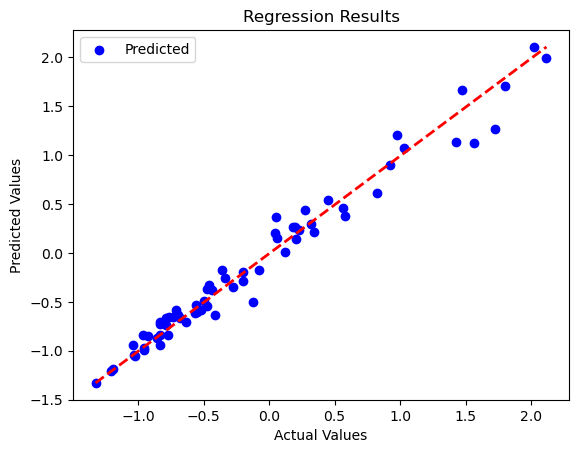

Cross-validated R^2 scores: [0.87498514 0.98261083 0.91434391 0.96621405 0.95879119]
Mean R^2 score: 0.9393890257903623


In [16]:
##############
# SVM nonlinear: splitting of dataset
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_nonlinear, perm_importance = SVM_nonlinear_select_fit(X_main, y_main, split_data=True, n_features=no_features)

# Prediction SVM results
y_pred_SVM = predict_SVM_nonlinear(X_test_rfe, y_test, svr_nonlinear)

# Visualize results
visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_nonlinear, X_rfe, y_main)

Best Hyperparameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.01}
Selected Features Indices (after permutation importance): [ 1 18 23  8  2]
Selected Features Names (after permutation importance): Index(['Vs (kn)', 'At (m2)', 'iE (deg)', 'Lcf (m)', 'T (m)'], dtype='object')
Mean Squared Error: 0.02
R^2 Score: 0.98


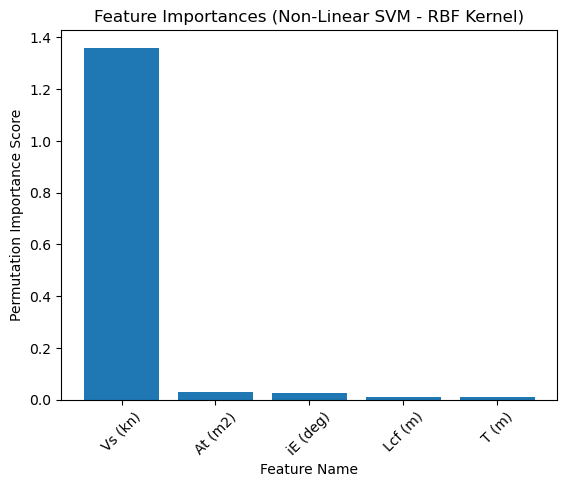

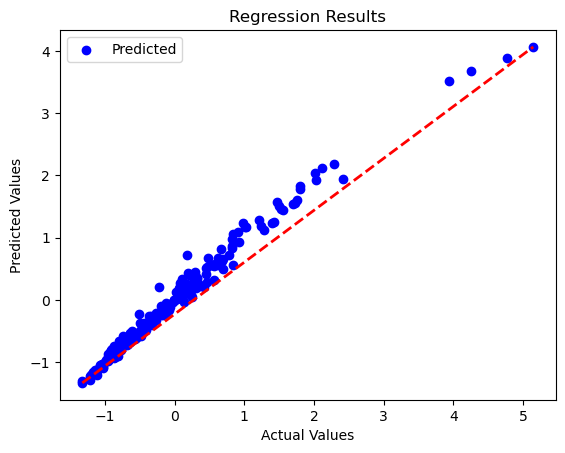

Cross-validated R^2 scores: [0.91917824 0.982923   0.91046518 0.9841921  0.94381084]
Mean R^2 score: 0.9481138707000453


In [17]:
##############
# SVM linear: no splitting of dataset
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_nonlinear, perm_importance = SVM_nonlinear_select_fit(X_main, y_main, n_features=no_features)

# Prediction SVM results
y_pred_SVM = predict_SVM_nonlinear(X_train_rfe, y_main, svr_nonlinear)

# Visualize results
visualize_feature_nonlinear_SVM(select_feat_SVM, perm_importance)
plot_pred_actual_results(y_main, y_pred_SVM)

# Cross-validation results
cross_validation(svr_nonlinear, X_train_rfe, y_main)